THƯ VIỆN SỬ DỤNG

In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import joblib
from sklearn.utils import resample

ĐỌC FILE

In [193]:
df = pd.read_csv(r"../data/HAM10000_metadata.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10124 entries, 0 to 10123
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10124 non-null  object 
 1   image_id      10124 non-null  object 
 2   dx            10124 non-null  object 
 3   dx_type       10124 non-null  object 
 4   age           10067 non-null  float64
 5   sex           10124 non-null  object 
 6   localization  10124 non-null  object 
 7   dataset       10124 non-null  object 
dtypes: float64(1), object(7)
memory usage: 632.9+ KB


In [194]:
df.shape

(10124, 8)

In [195]:
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10124 entries, 0 to 10123
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10124 non-null  object 
 1   image_id      10124 non-null  object 
 2   dx            10124 non-null  object 
 3   dx_type       10124 non-null  object 
 4   age           10067 non-null  float64
 5   sex           10124 non-null  object 
 6   localization  10124 non-null  object 
 7   dataset       10124 non-null  object 
dtypes: float64(1), object(7)
memory usage: 632.9+ KB


XEM VÀ XỬ LÍ MISSING VALUES

In [197]:
# Tính tỉ lệ giá trị null trong mỗi cột
null_values = (df.isnull().sum() / df.shape[0] ) * 100
print(" % null mỗi cột:\n", null_values)

 % null mỗi cột:
 lesion_id       0.000000
image_id        0.000000
dx              0.000000
dx_type         0.000000
age             0.563019
sex             0.000000
localization    0.000000
dataset         0.000000
dtype: float64


In [198]:
# Do missing values chỉ xuất hiện ở cột "age" và tỉ lệ thấp => giữ và thay bằng giá trị trung vị 
df["age"] = df["age"].fillna(df["age"].median())
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dataset         0
dtype: int64

Text(0.5, 0, 'Age')

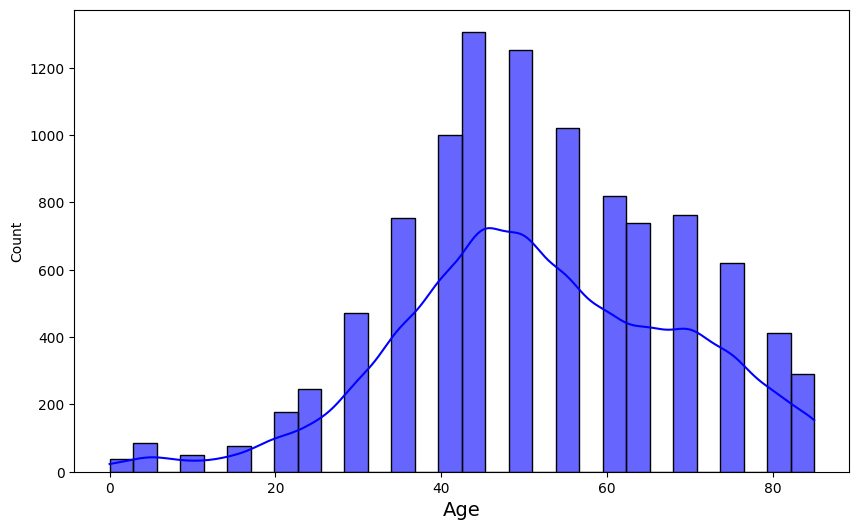

In [199]:
# Hiển thị phân phối của các cột dữ liệu số
plt.figure(figsize=(10,6))
sns.histplot(df['age'], bins=30, kde=True, color='blue', alpha=0.6)
plt.xlabel('Age', fontsize=14)

KIỂM TRA VÀ XỬ LÍ CÂN BẰNG DỮ LIỆU

In [200]:
# Kiểm tra số lượng mỗi loại tổn thương da
df['dx'].value_counts()

dx
nv         6705
mel        1113
bkl        1099
bcc         514
akiec       327
vasc        142
df          115
healthy     109
Name: count, dtype: int64

In [201]:
# Định nghĩa các class ác tính và lành tính
malignant = ["mel", "bcc", "akiec", "vasc"] # ác tính 1
benign = ["nv", "df", "bkl"] # lành tính 0

In [202]:
# Lọc dữ liệu chỉ giữ lại các class ác tính và lành tính
df = df[df["dx"].isin(malignant + benign)].copy()
df["target"] = df["dx"].apply(lambda x: 1 if x in malignant else 0)
df["target"].value_counts()

target
0    7919
1    2096
Name: count, dtype: int64

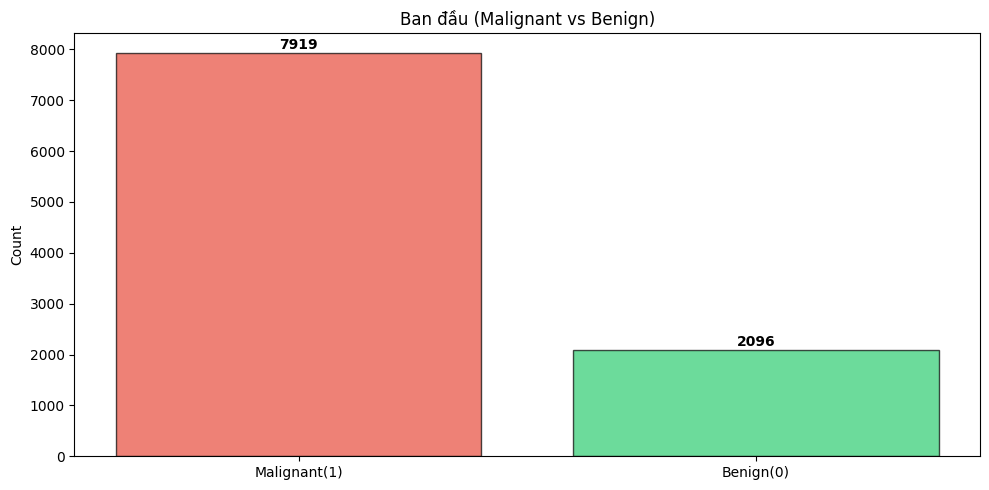

Imbalance Ratio (Benign : Malignant) = 0.26 : 1


In [203]:
plt.figure(figsize=(10, 5))

# Đếm số lượng theo class (giữ đúng thứ tự 0, 1)
class_counts = df['target'].value_counts().sort_index()

labels = ['Malignant(1)', 'Benign(0)']
colors = ['#e74c3c', '#2ecc71']  # đỏ = ác tính, xanh = lành tính

# Bar plot
plt.bar(labels, class_counts.values, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Count')
plt.title('Ban đầu (Malignant vs Benign)')

# Hiển thị số lượng trên cột
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 0.01 * max(class_counts.values), str(v),
             ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Tính tỷ lệ mất cân bằng
imbalance_ratio = class_counts[1] / class_counts[0]
print(f"Imbalance Ratio (Benign : Malignant) = {imbalance_ratio:.2f} : 1")


In [204]:
# Hàm cân bằng lại dataset
def balance_dataset_by_type(data):
    """
    Downsample the majority class (Benign = 1) to balance with the minority class (Malignant = 0).
    """

    # Tách dữ liệu theo class
    malignant_df = data[data["target"] == 1]   
    benign_df = data[data["target"] == 0]      # downsample benign class

    # Downsample benign class
    benign_downsampled = resample(
        benign_df,
        replace=False,
        n_samples=len(malignant_df),
        random_state=42
    )

    # Kết hợp lại dữ liệu đã cân bằng
    balanced_data = pd.concat(
        [malignant_df, benign_downsampled],
        ignore_index=True
    ).sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_data

# Cân bằng lại dataset
df_balanced = balance_dataset_by_type(df)

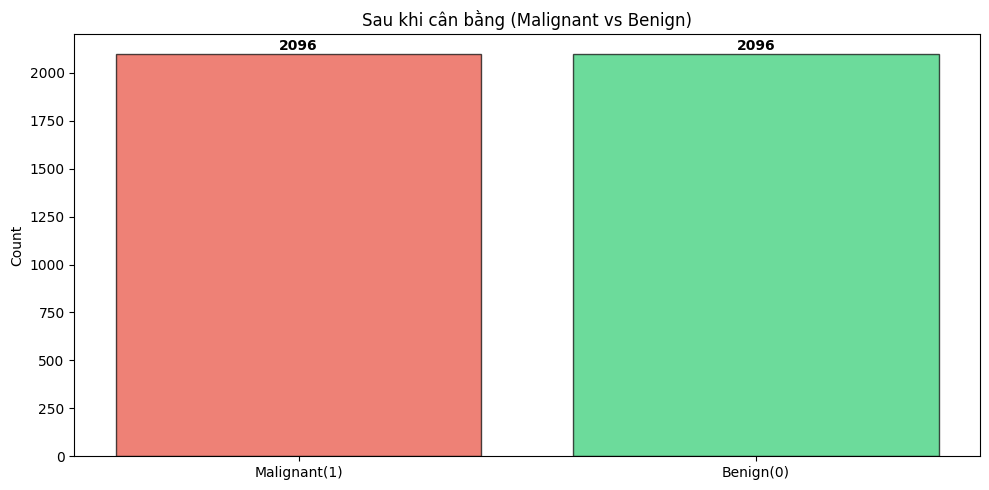

In [205]:
plt.figure(figsize=(10, 5))

# Đếm số lượng theo class (giữ đúng thứ tự 0, 1)
class_counts = df_balanced['target'].value_counts().sort_index()

labels = ['Malignant(1)', 'Benign(0)']
colors = ['#e74c3c', '#2ecc71']  # đỏ = ác tính, xanh = lành tính

# Bar plot
plt.bar(labels, class_counts.values, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Count')
plt.title('Sau khi cân bằng (Malignant vs Benign)')

# Hiển thị số lượng trên cột
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 0.01 * max(class_counts.values), str(v),
             ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [206]:
df_balanced.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dataset', 'target'],
      dtype='object')

CHỌN FEATURES VÀ TARGET

In [207]:
for col in df_balanced.columns:
    print(f"{col}: {df[col].nunique()}" )

lesion_id: 7470
image_id: 10015
dx: 7
dx_type: 4
age: 18
sex: 3
localization: 15
dataset: 4
target: 2


In [208]:
features = df_balanced.drop(columns=['lesion_id','image_id', 'dx', 'target'])
target = df_balanced['target']

ONE HOT ENCODE CHO FEATURES

In [209]:
# One-hot encode categorical features
cat_cols = features.select_dtypes(include=['object', 'category']).columns.tolist()

df_encoded = pd.get_dummies(
    features,
    columns=cat_cols,
    drop_first=False
)
df_encoded = df_encoded.astype(int)

In [210]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   age                           4192 non-null   int64
 1   dx_type_confocal              4192 non-null   int64
 2   dx_type_consensus             4192 non-null   int64
 3   dx_type_follow_up             4192 non-null   int64
 4   dx_type_histo                 4192 non-null   int64
 5   sex_female                    4192 non-null   int64
 6   sex_male                      4192 non-null   int64
 7   sex_unknown                   4192 non-null   int64
 8   localization_abdomen          4192 non-null   int64
 9   localization_acral            4192 non-null   int64
 10  localization_back             4192 non-null   int64
 11  localization_chest            4192 non-null   int64
 12  localization_ear              4192 non-null   int64
 13  localization_face             419

CHIA TẬP DỮ LIỆU HUẤN LUYỆN

In [211]:
# stratify=target: giữ nguyên tỷ lệ các lớp (nhãn) trong tập train và test
x_train ,x_test, y_train, y_test = train_test_split(df_encoded, target, test_size=0.2, random_state=42, stratify=target)

In [212]:
print(x_train.shape)
print(y_train.shape)
print("------------------")
print(x_test.shape)
print(y_test.shape)

(3353, 27)
(3353,)
------------------
(839, 27)
(839,)


CHUẨN HÓA DỮ LIỆU

In [213]:
num_cols = features.select_dtypes(include=["int64", "float64"]).columns

x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

scaler = StandardScaler()
x_train_scaled[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test_scaled[num_cols] = scaler.transform(x_test[num_cols])

In [214]:
x_train_scaled.shape 

(3353, 27)

In [215]:
print(x_train_scaled)

           age  dx_type_confocal  dx_type_consensus  dx_type_follow_up  \
4031 -0.644086                 0                  0                  0   
1827  1.396593                 0                  0                  0   
1359 -0.644086                 0                  0                  0   
3623 -0.644086                 0                  0                  1   
2769  0.522016                 0                  0                  0   
...        ...               ...                ...                ...   
1040 -1.227137                 0                  0                  0   
3577 -0.935612                 0                  0                  0   
1130 -0.644086                 0                  0                  0   
3376 -1.227137                 0                  0                  0   
1571  0.813541                 0                  0                  0   

      dx_type_histo  sex_female  sex_male  sex_unknown  localization_abdomen  \
4031              1           1

XUẤT DATASET

In [216]:
# Add code to save dataset and load it later
joblib.dump(x_train_scaled, '../data/binary_class/x_train_scaled_binary_class.pkl')
joblib.dump(x_test_scaled, '../data/binary_class/x_test_scaled_binary_class.pkl')
joblib.dump(y_train, '../data/binary_class/y_train_binary_class.pkl')
joblib.dump(y_test, '../data/binary_class/y_test_binary_class.pkl')

['../data/binary_class/y_test_binary_class.pkl']